In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
from tqdm import tqdm
import obtain_data

In [2]:
# Load the dataset
obtain_data.main(50, ratings=False)
print("Loading dataset...")
df = pd.read_csv('movie_info/trakt_movie_info.csv')
print(f"Dataset loaded with {len(df)} rows")

df.head()

Fetched 500 trending movies in 11.27 seconds.
Movie certifications and poster URLs fetched/stored successfully in 42.13 seconds.
Movie posters stored successfully in 42.15 seconds.
Loading dataset...
Dataset loaded with 500 rows


,title,year,ids.trakt,ids.slug,ids.imdb,ids.tmdb,watchers,certification,poster_url
0,Mickey 17,2025,540151,mickey-17-2025,tt12299608,696506,1638,R,https://walter-r2.trakt.tv/images/movies/000/5...
1,A Minecraft Movie,2025,763995,a-minecraft-movie-2025,tt3566834,950387,1095,PG,https://walter-r2.trakt.tv/images/movies/000/7...
2,Novocaine,2025,964679,novocaine-2025,tt29603959,1195506,945,R,https://walter-r2.trakt.tv/images/movies/000/9...
3,A Working Man,2025,966319,a-working-man-2025,tt9150192,1197306,723,R,https://walter-r2.trakt.tv/images/movies/000/9...
4,In the Lost Lands,2025,205119,in-the-lost-lands-2025,tt4419684,324544,704,R,https://walter-r2.trakt.tv/images/movies/000/2...


In [3]:
# Check unique certifications and their counts
certification_counts = df['certification'].value_counts()
print("Top 10 certifications:")
print(certification_counts.head(10))

# Focus on certifications with at least 20 movies
min_samples = 20
common_certifications = certification_counts[certification_counts >= min_samples].index.tolist()
print(f"\ncertifications with at least {min_samples} samples: {len(common_certifications)}")
print(common_certifications)

# Filter dataset to include only common certifications
df_filtered = df[df['certification'].isin(common_certifications)]
print(f"Dataset size after filtering: {len(df_filtered)} movies")

Top 10 certifications:
certification
PG-13    180
R        172
PG       105
G         22
NR         3
Name: count, dtype: int64

certifications with at least 20 samples: 4
['PG-13', 'R', 'PG', 'G']
Dataset size after filtering: 479 movies


In [4]:
# Create a label encoder for the certifications
label_encoder = LabelEncoder()
df_filtered['encoded_certification'] = label_encoder.fit_transform(df_filtered['certification'])
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")

# Show label mapping
for i, certification in enumerate(label_encoder.classes_):
    print(f"{certification} -> {i}")

Number of classes: 4
G -> 0
PG -> 1
PG-13 -> 2
R -> 3


/var/folders/6t/fjwg1l_51rvd4b3ygb5c4cq80000gn/T/ipykernel_33227/1518604792.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['encoded_certification'] = label_encoder.fit_transform(df_filtered['certification'])


In [5]:
# Download and process a movie poster
def download_poster(poster_path, img_size=(224, 224)):

    url = poster_path
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        img = img.resize(img_size)
        img = img.convert('RGB')
        return np.array(img) / 255.0
    except Exception as e:
        print(f"Error downloading {url}: {e}")
        return None

# Download and save all posters to a npy file
def download_all_posters(dataframe, output_file='cnn_files/movie_posters.npy', img_size=(224, 224)):
    print(f"Downloading {len(dataframe)} posters...")
    X = []
    y = []

    for i, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        img = download_poster(row['poster_url'], img_size)
        if img is not None:
            X.append(img)
            y.append(row['encoded_certification'])
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"Downloaded {len(X)} posters of shape {X[0].shape}")
    
    # Save\
    np.save(f"{output_file}_images", X)
    np.save(f"{output_file}_labels", y)
    
    print(f"Data saved to {output_file}_images.npy and {output_file}_labels.npy")
    
    return X, y

In [6]:
# For demonstration, we use a smaller subset first
sample_size = min(500, len(df_filtered))
df_sample = df_filtered.sample(sample_size, random_state=42)

if not os.path.exists('cnn_files'):
    os.makedirs('cnn_files')

# Download and save the posters
X, y = download_all_posters(df_sample, 'cnn_files/movie_posters')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

# Build the CNN
input_shape = X_train[0].shape
print(f"Input shape: {input_shape}")

  0%|          | 0/479 [00:00<?, ?it/s]

100%|██████████| 479/479 [00:24<00:00, 19.68it/s]


Downloaded 479 posters of shape (224, 224, 3)
Data saved to cnn_files/movie_posters_images.npy and cnn_files/movie_posters_labels.npy
Training set: (383, 224, 224, 3)
Testing set: (96, 224, 224, 3)
Input shape: (224, 224, 3)


In [7]:
# Create the CNN
model = models.Sequential([
    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Fourth convolutional block
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3)
]

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)        0

In [8]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/25
12/12 [==============================] - 11s 854ms/step - loss: 1.8586 - accuracy: 0.3368 - val_loss: 1.3138 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 2/25
12/12 [==============================] - 10s 761ms/step - loss: 1.2394 - accuracy: 0.3499 - val_loss: 1.1970 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 3/25
12/12 [==============================] - 8s 686ms/step - loss: 1.1972 - accuracy: 0.4204 - val_loss: 1.1462 - val_accuracy: 0.3854 - lr: 0.0010
Epoch 4/25
12/12 [==============================] - 9s 791ms/step - loss: 1.1502 - accuracy: 0.4282 - val_loss: 1.1329 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 5/25
12/12 [==============================] - 9s 760ms/step - loss: 1.1201 - accuracy: 0.4517 - val_loss: 1.1166 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 6/25
12/12 [==============================] - 8s 706ms/step - loss: 1.0723 - accuracy: 0.4778 - val_loss: 1.0917 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 7/25
12/12 [==============================] - 9s 725ms/step - 

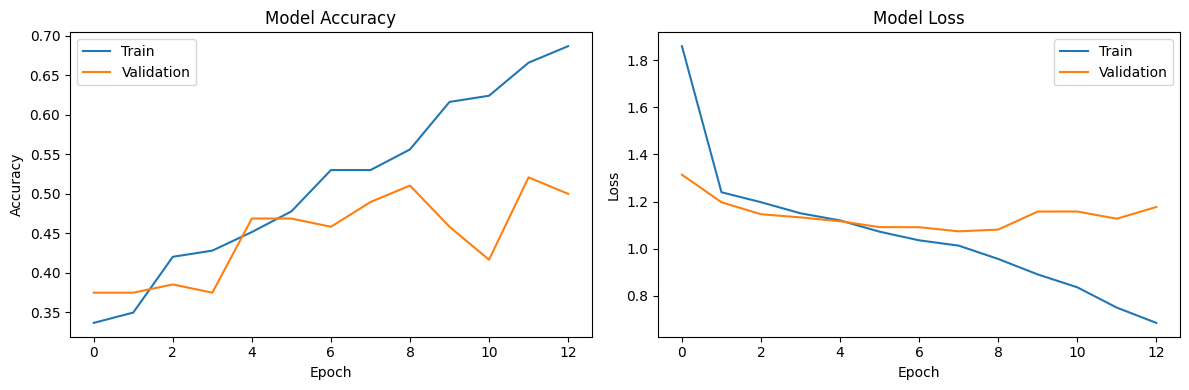

In [15]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

In [16]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, 
                            target_names=label_encoder.classes_))


3/3 [==============================] - 1s 203ms/step - loss: 1.0737 - accuracy: 0.4896
Test accuracy: 0.4896
3/3 [==============================] - 1s 184ms/step

Classification Report:
              precision    recall  f1-score   support

           G       0.00      0.00      0.00         4
          PG       0.57      0.38      0.46        21
       PG-13       0.50      0.28      0.36        36
           R       0.47      0.83      0.60        35

    accuracy                           0.49        96
   macro avg       0.38      0.37      0.35        96
weighted avg       0.48      0.49      0.45        96



/Users/dhruvgandhi/anaconda3/envs/class_files/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dhruvgandhi/anaconda3/envs/class_files/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dhruvgandhi/anaconda3/envs/class_files/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [17]:
# Save the model and encoder
model.save('cnn_files/movie_certification_cnn_model.keras')
print("Model saved as 'movie_certification_cnn_model'")

import pickle
with open('cnn_files/certification_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("Label encoder saved as 'certification_encoder.pkl'")

Model saved as 'movie_certification_cnn_model'
Label encoder saved as 'certification_encoder.pkl'


In [18]:
# Function to predict certification from a new poster
def predict_certification(poster_path):
    # Download and preprocess the image
    img = download_poster(poster_path)
    if img is None:
        return None
    
    # Reshape for prediction
    img = np.expand_dims(img, axis=0)
    
    # Make prediction
    prediction = model.predict(img)
    class_idx = np.argmax(prediction[0])
    confidence = prediction[0][class_idx]
    
    # Convert back to certification
    certification = label_encoder.inverse_transform([class_idx])[0]
    
    return certification, confidence

1/1 [==============================] - 0s 25ms/step
Movie: Mickey 17
True certification: R
Predicted certification: R
Confidence: 49.39%


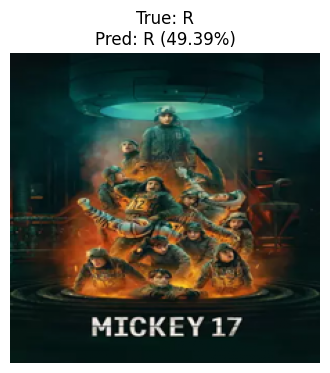

In [19]:
# Example prediction
test_poster = df_filtered['poster_url'].iloc[0]
true_certification = df_filtered['certification'].iloc[0]
pred_certification, confidence = predict_certification(test_poster)

print(f"Movie: {df_filtered['title'].iloc[0]}")
print(f"True certification: {true_certification}")
print(f"Predicted certification: {pred_certification}")
print(f"Confidence: {confidence:.2%}")

# Display the test image with prediction
test_img = download_poster(test_poster)
plt.figure(figsize=(4, 6))
plt.imshow(test_img)
plt.title(f"True: {true_certification}\nPred: {pred_certification} ({confidence:.2%})")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 23ms/step


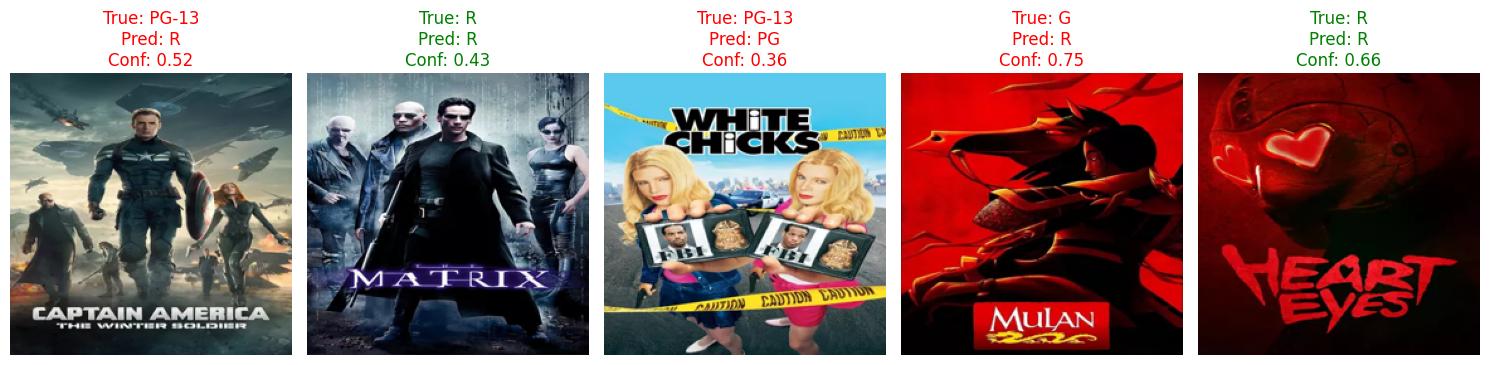

In [20]:
# Visualize some predictions
def display_predictions(num_samples=5):
    plt.figure(figsize=(15, 4))
    
    # Randomly select samples from the test set
    indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i+1)
        
        # Get prediction
        img = X_test[idx]
        true_label = label_encoder.inverse_transform([y_test[idx]])[0]
        
        # Reshape for prediction
        img_input = np.expand_dims(img, axis=0)
        pred = model.predict(img_input)
        pred_idx = np.argmax(pred[0])
        pred_label = label_encoder.inverse_transform([pred_idx])[0]
        confidence = pred[0][pred_idx]
        
        # Display image and prediction
        plt.imshow(img)
        title = f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}"
        color = 'green' if true_label == pred_label else 'red'
        plt.title(title, color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Show some example predictions
display_predictions(5)